## Практическое задание  
  
Используем набор примеров fashion-MNIST

1.  Опишите - какой результата получен в нейросети в зависимости от:
  -  числа нейронов в слое(для 2-хслойной сети), 
  - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
  - фиксируйте для тренировочного и тестового набора метрики accuracy.
2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе? 

4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical, plot_model
from keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import L1

2022-04-14 12:59:00.297930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-14 12:59:00.298018: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 0. Loading data

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
X = np.concatenate((X_train, X_test)).copy()
y = np.concatenate((y_train, y_test)).copy()

According to the dataset description we have following classes:  

In [4]:
map_classes = {0: 'T-shirt/top ', 1: 'Trouser', 2: 'Pullover', 
               3: 'Dress', 4: 'Coat', 5: 'Sandal', 
               6: 'Shirt', 7:'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

Let's look at some examples

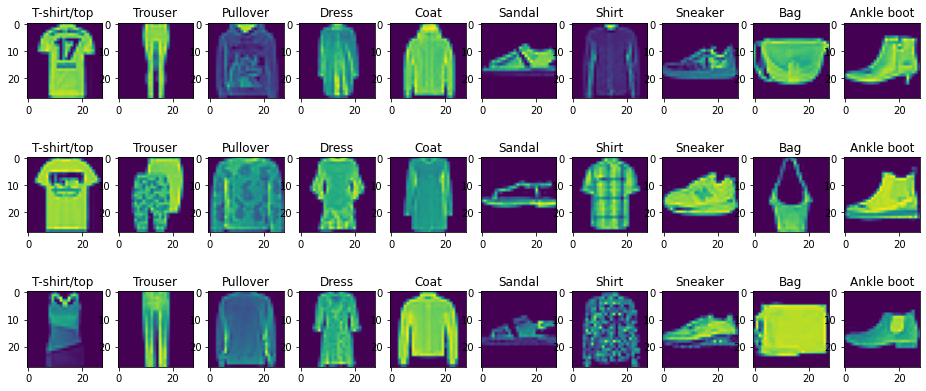

In [5]:
fig, ax = plt.subplots(3, 10, figsize=(16, 7))
np.random.seed(7575)

for row in range(3):
    for col in range(10):
        idx = np.where(y == col)
        id = np.random.choice(idx[0])
        ax[row][col].imshow(X[id, :, :])
        ax[row][col].set_title(map_classes[y[id]])
        
plt.show()

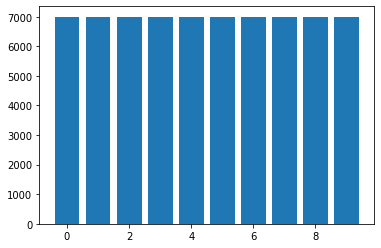

In [6]:
(unique, counts) = np.unique(y, return_counts=True)
plt.bar(unique, height=counts)
plt.show()

Our classes are distrubuted as magicly good as possible, so we don't worry about need of undersampling/oversampling here.


### Small preprocess
  
We need to rescale (normalize) each of our pixels to be better interpreted by our model.  
  
`X_train.shape -> (60000, 28, 28)`
  
Also, at first we had 60000 training matrices, each with shape (28, 28). And now we flatten them to get the input vectors.  
  
`X_train.shape -> (60000, 784)`


In [7]:
# Normalize the images.
X_train = (X_train / 255) - 0.5
X_test = (X_test / 255) - 0.5
X = (X / 255) - 0.5

# Flatten the images.
X_train = X_train.reshape((-1, 784))
X_test = X_test.reshape((-1, 784))
X = X.reshape((-1, 784))

## 1.1 Trying how the quantity of neurons in a layer influence the result

2022-04-14 12:59:14.963541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 12:59:14.964620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-14 12:59:14.964861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-14 12:59:14.965066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-14 12:59:14.965265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

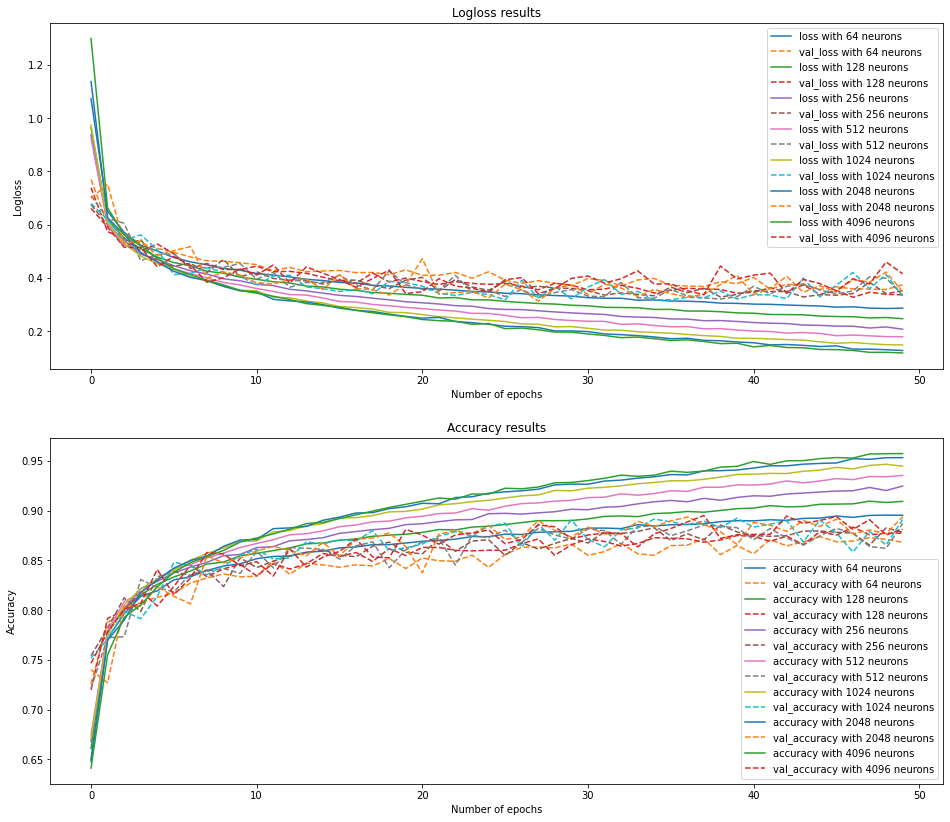

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
ephochs_n = 50

for i in range(5, 12):
    model = Sequential([
        Dense(2 ** (i + 1), activation='relu', input_shape=(784,)),
        Dense(10, activation='softmax')])

    model.compile(
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    history = model.fit(X,
                        to_categorical(y),
                        epochs=ephochs_n,
                        batch_size=2048,
                        validation_split=0.2,
                        verbose=0)

    ax1.plot(range(ephochs_n), history.history['loss'], '-', label=f'loss with {2 ** (i + 1)} neurons')
    ax1.plot(range(ephochs_n), history.history['val_loss'], '--', label=f'val_loss with {2 ** (i + 1)} neurons')
    ax2.plot(range(ephochs_n), history.history['accuracy'], '-', label=f'accuracy with {2 ** (i + 1)} neurons')
    ax2.plot(range(ephochs_n), history.history['val_accuracy'], '--', label=f'val_accuracy with {2 ** (i + 1)} neurons')

ax1.set_title('Logloss results')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Logloss')
ax1.legend()
ax2.set_title('Accuracy results')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

**Conclusions:** the more neurons in a layer we have, the better (faster) model overfits :)  
  
If we look at the validation scores we can see a high variance and that the neurons quantity doesn't affect the validation score as much as affects the training one.  
  
So after all, I will pick the model with 512 neurons, because its validation score doesn't differ to much from scores of other model

## 1.2 Trying how  quantity of layers influence the result
I try to manually choose the number of neurons in each layer in a way, that the quantity of total trainable params will be about 407,050 (that's the number of trainable parameters in a NN with 1 hidden layer and 512 neurons in it)

In [9]:
n = 512
model1 = Sequential([
    Dense(n, activation='relu', input_shape=(784,)),
    Dense(10, activation='softmax')])

n2 = 295
model2 = Sequential([
    Dense(n2, activation='relu', input_shape=(784,)),
    Dense(n2, activation='relu'),
    Dense(n2, activation='relu'),
    Dense(10, activation='softmax')])

n3 = 235
model3 = Sequential([
    Dense(n3, activation='relu', input_shape=(784,)),
    Dense(n3, activation='relu'),
    Dense(n3, activation='relu'),
    Dense(n3, activation='relu'),
    Dense(n3, activation='relu'),
    Dense(10, activation='softmax')])

n4 = 173
model4 = Sequential([
    Dense(n4, activation='relu', input_shape=(784,)),
    Dense(n4, activation='relu'),
    Dense(n4, activation='relu'),
    Dense(n4, activation='relu'),
    Dense(n4, activation='relu'),
    Dense(n4, activation='relu'),
    Dense(n4, activation='relu'),
    Dense(n4, activation='relu'),
    Dense(n4, activation='relu'),
    Dense(n4, activation='relu'),
    Dense(10, activation='softmax')])

model1.summary()
model2.summary()
model3.summary()
model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               401920    
                                                                 
 dense_15 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 295)               231575    
                                                                 
 dense_17 (Dense)            (None, 295)               87320     
                                                                 
 dense_18 (Dense)         

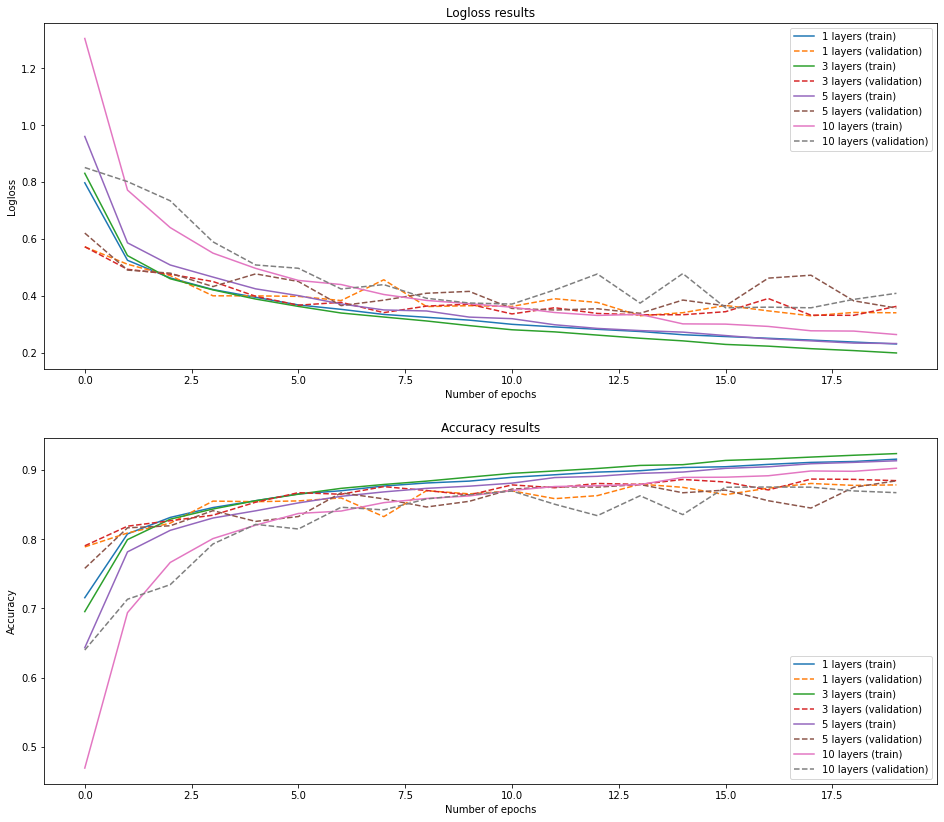

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
ephochs_n = 20

model_idx_to_layers_quant = {0: 1, 1: 3, 2: 5, 3: 10}
for i, m in enumerate([model1, model2, model3, model4]):
    m.compile(
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    history = m.fit(X,
                    to_categorical(y),
                    epochs=ephochs_n,
                    batch_size=1024,
                    validation_split=0.2,
                    verbose=0)

    ax1.plot(range(ephochs_n), history.history['loss'], '-', label=f'{model_idx_to_layers_quant[i]} layers (train)')
    ax1.plot(range(ephochs_n), history.history['val_loss'], '--', label=f'{model_idx_to_layers_quant[i]} layers (validation)')
    ax2.plot(range(ephochs_n), history.history['accuracy'], '-', label=f'{model_idx_to_layers_quant[i]} layers (train)')
    ax2.plot(range(ephochs_n), history.history['val_accuracy'], '--', label=f'{model_idx_to_layers_quant[i]} layers (validation)')

ax1.set_title('Logloss results')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Logloss')
ax1.legend()
ax2.set_title('Accuracy results')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

According to charts above, the best results were reached with a NN with 3 hidden layers

## 2. Trying how different optimizers influence the result

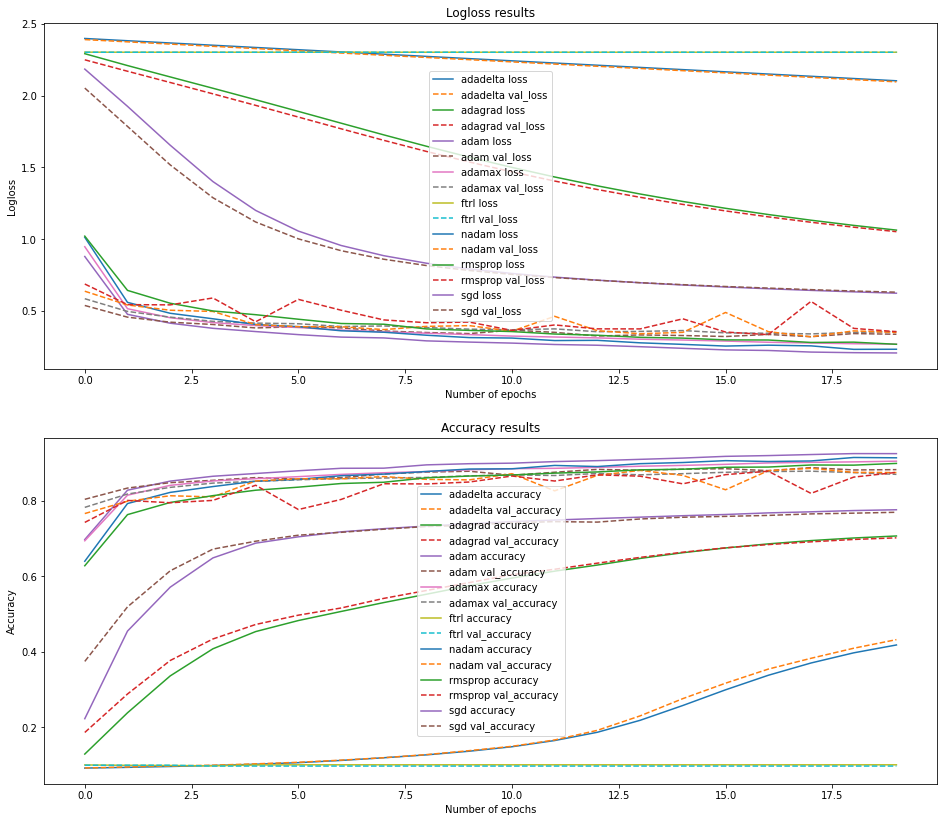

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
ephochs_n = 20

optimizers = ['adadelta', 'adagrad', 'adam', 'adamax', 'ftrl', 'nadam', 'rmsprop', 'sgd']

for optimizer in optimizers:
    model = Sequential([
        Dense(295, activation='relu', input_shape=(784,)),
        Dense(295, activation='relu'),
        Dense(295, activation='relu'),
        Dense(10, activation='softmax')])

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    history = model.fit(X,
                        to_categorical(y),
                        epochs=ephochs_n,
                        batch_size=2048,
                        validation_split=0.2,
                        verbose=0)

    ax1.plot(range(ephochs_n), history.history['loss'], '-', label=f'{optimizer} loss')
    ax1.plot(range(ephochs_n), history.history['val_loss'], '--', label=f'{optimizer} val_loss')
    ax2.plot(range(ephochs_n), history.history['accuracy'], '-', label=f'{optimizer} accuracy')
    ax2.plot(range(ephochs_n), history.history['val_accuracy'], '--', label=f'{optimizer} val_accuracy')

ax1.set_title('Logloss results')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Logloss')
ax1.legend()
ax2.set_title('Accuracy results')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

At this point, expectedly, the choice of the optimizer has influenced the result the most  
  
The best optimizer is `adam`, according to the schedule above

## Building a model with the 'best' parameters

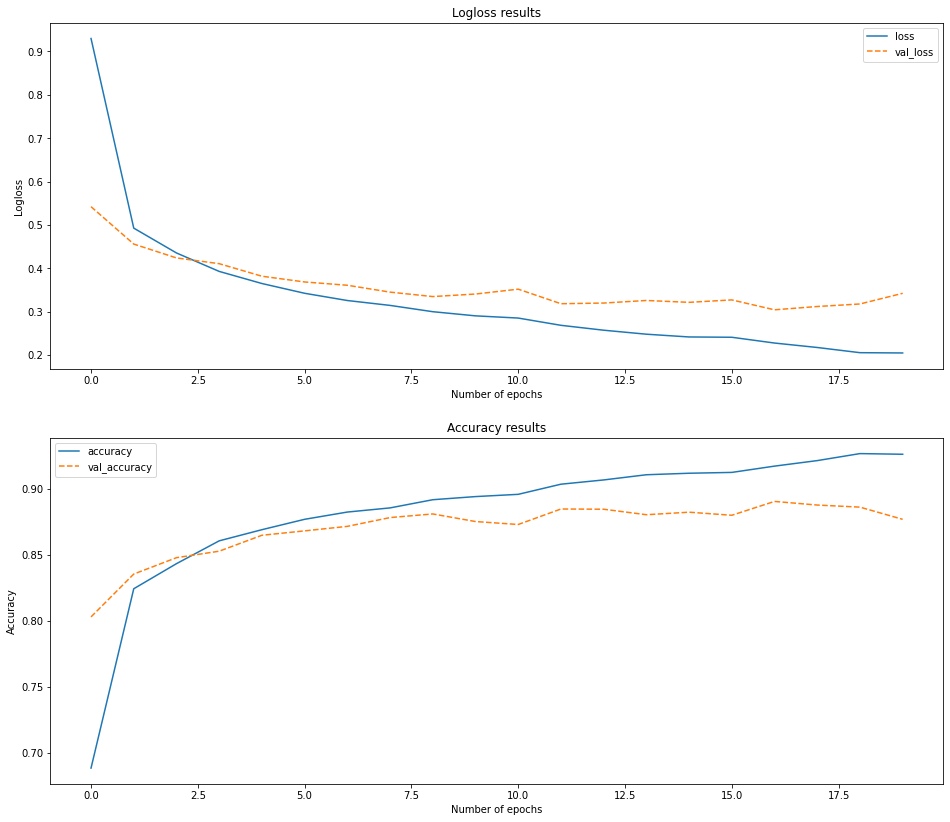

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
ephochs_n = 20

final_model = Sequential([
        Dense(295, activation='relu', input_shape=(784,)),
        Dense(295, activation='relu'),
        Dense(295, activation='relu'),
        Dense(10, activation='softmax')])

final_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history = final_model.fit(X_train,
                          to_categorical(y_train),
                          epochs=ephochs_n,
                          batch_size=2048,
                          validation_split=0.2,
                          verbose=0)

ax1.plot(range(ephochs_n), history.history['loss'], '-', label=f'loss')
ax1.plot(range(ephochs_n), history.history['val_loss'], '--', label=f'val_loss')
ax2.plot(range(ephochs_n), history.history['accuracy'], '-', label=f'accuracy')
ax2.plot(range(ephochs_n), history.history['val_accuracy'], '--', label=f'val_accuracy')
ax1.set_title('Logloss results')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Logloss')
ax1.legend()
ax2.set_title('Accuracy results')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [13]:
results = final_model.evaluate(X_test, to_categorical(y_test))
print(f'logloss -> {results[0]}\naccuracy -> {results[1]}')

313/313 [==============================] - 1s 2ms/step - loss: 0.3724 - accuracy: 0.8726
logloss -> 0.3724444806575775
accuracy -> 0.8726000189781189


Here we can clearly see the overfitting problem, caused by overloaded NN structure. It has to big capacity and final model has a high varince.  
  
We can avoid such problem by decreasing quantity of neurons in a layer and increasing of training epochs.

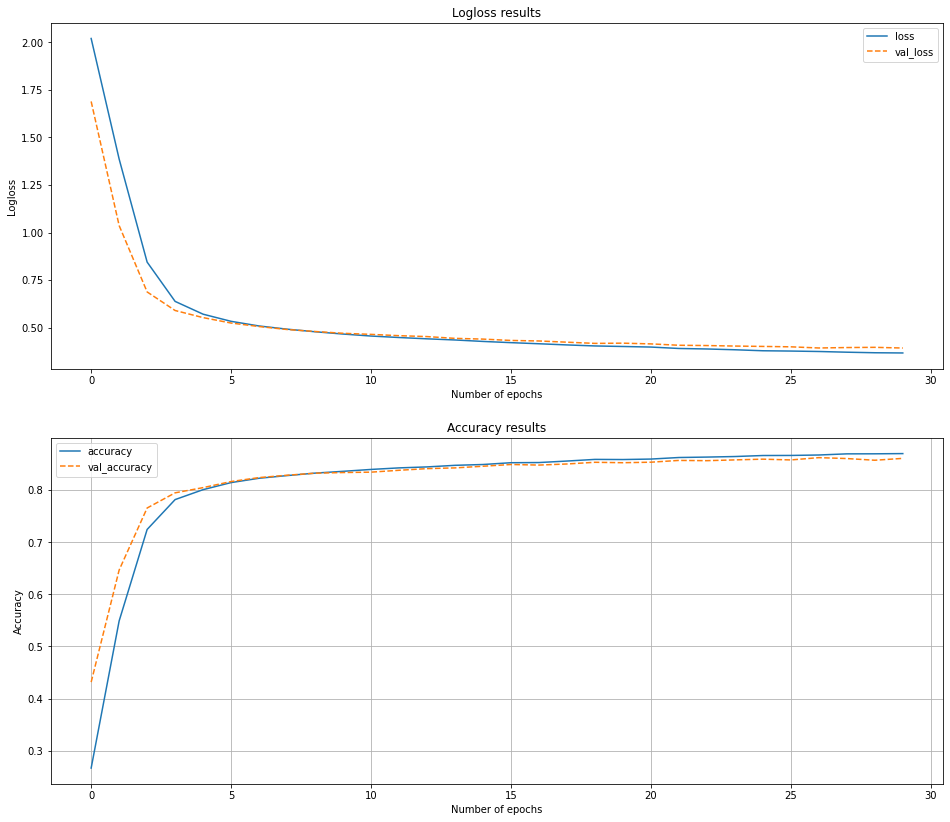

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
ephochs_n = 30

final_model1 = Sequential([
        Dense(20, activation='relu', input_shape=(784,)),
        Dense(20, activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='softmax')])

final_model1.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history = final_model1.fit(X_train,
                          to_categorical(y_train),
                          epochs=ephochs_n,
                          batch_size=2048,
                          validation_split=0.2,
                          verbose=0)

ax1.plot(range(ephochs_n), history.history['loss'], '-', label=f'loss')
ax1.plot(range(ephochs_n), history.history['val_loss'], '--', label=f'val_loss')
ax2.plot(range(ephochs_n), history.history['accuracy'], '-', label=f'accuracy')
ax2.plot(range(ephochs_n), history.history['val_accuracy'], '--', label=f'val_accuracy')
ax1.set_title('Logloss results')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Logloss')
ax1.legend()
ax2.set_title('Accuracy results')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.grid('On')
plt.show()

In [15]:
results = final_model1.evaluate(X_test, to_categorical(y_test))
print(f'logloss -> {results[0]}\naccuracy -> {results[1]}')

313/313 [==============================] - 0s 1ms/step - loss: 0.4278 - accuracy: 0.8509
logloss -> 0.4277820885181427
accuracy -> 0.8508999943733215


Now we have much lower model variance! Unfortunately our overall validation score have also decreased (model bias has increased)  
  
That's because our NN structure is now to simple.
  
Let's find an optimum complexity of the NN.

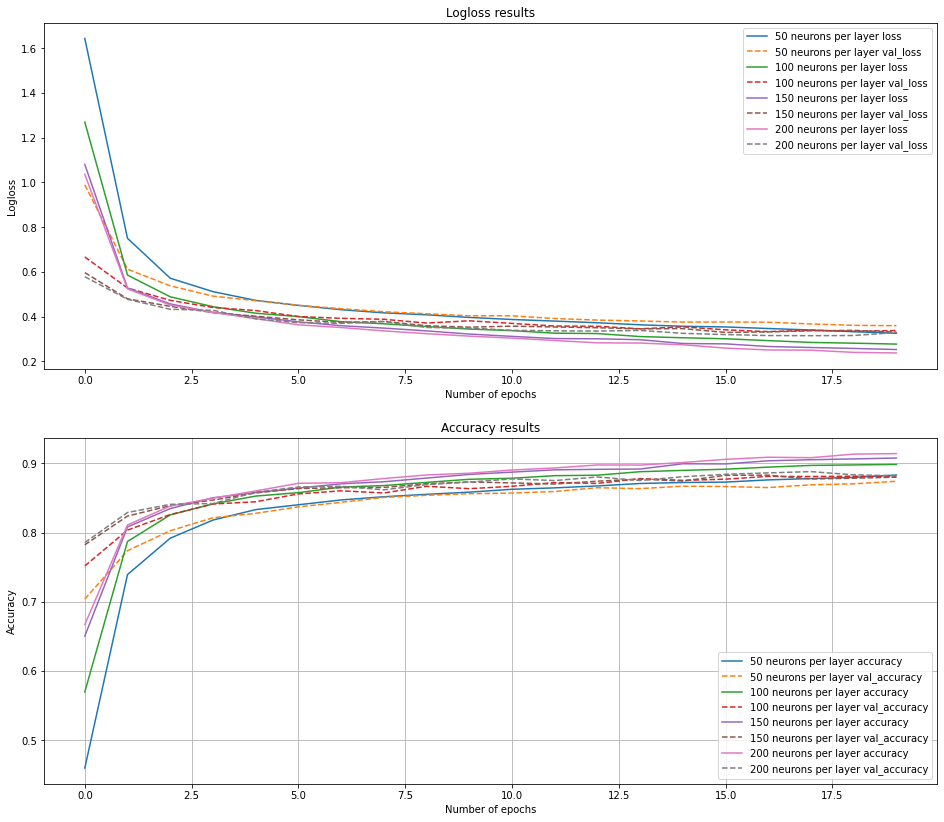

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
ephochs_n = 20
neurons_quant = np.arange(0, 201, 50)

for neur_quant in neurons_quant[1:]:
    
    final_model2 = Sequential([
            Dense(neur_quant, activation='relu', input_shape=(784,)),
            Dense(neur_quant, activation='relu'),
            Dense(neur_quant, activation='relu'),
            Dense(10, activation='softmax')])

    final_model2.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

    history = final_model2.fit(X_train,
                              to_categorical(y_train),
                              epochs=ephochs_n,
                              batch_size=2048,
                              validation_split=0.2,
                              verbose=0)

    ax1.plot(range(ephochs_n), history.history['loss'], '-', label=f'{neur_quant} neurons per layer loss')
    ax1.plot(range(ephochs_n), history.history['val_loss'], '--', label=f'{neur_quant} neurons per layer val_loss')
    ax2.plot(range(ephochs_n), history.history['accuracy'], '-', label=f'{neur_quant} neurons per layer accuracy')
    ax2.plot(range(ephochs_n), history.history['val_accuracy'], '--', label=f'{neur_quant} neurons per layer val_accuracy')
    
ax1.set_title('Logloss results')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Logloss')
ax1.legend()
ax2.set_title('Accuracy results')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.grid('On')
plt.show()

In [17]:
results = final_model2.evaluate(X_test, to_categorical(y_test))
print(f'logloss -> {results[0]}\naccuracy -> {results[1]}')

313/313 [==============================] - 0s 1ms/step - loss: 0.3565 - accuracy: 0.8762
logloss -> 0.35648635029792786
accuracy -> 0.8762000203132629


Seems like 200 neurons and 3 hidden layers provides us with much more reliable and even simply higher validation score!  
  
I could continue trying different NN structures, it should probably give us even better score, but I think the quantity of tweaks, I've done, for just one lesson is fairly enough :) 

## Building the error matrix

In [18]:
y_pred = final_model2.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


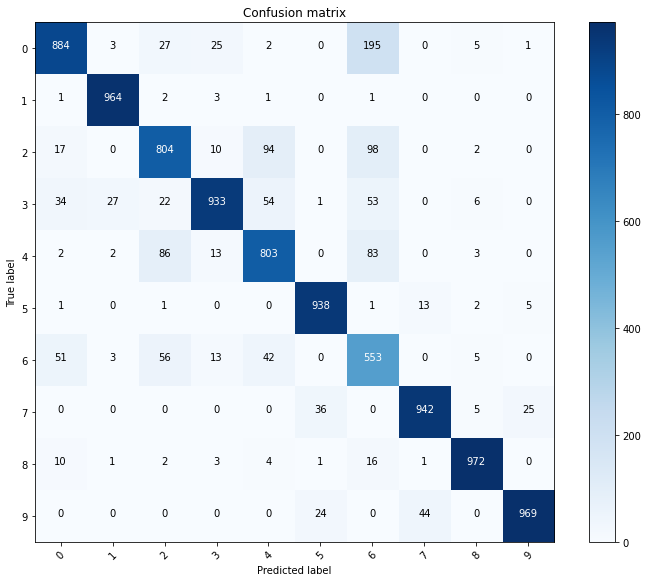

In [20]:
cnf_matrix = confusion_matrix(y_pred_class, y_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      title='Confusion matrix')

In [ ]:
map_classes = {0: 'T-shirt/top ', 1: 'Trouser', 2: 'Pullover', 
               3: 'Dress', 4: 'Coat', 5: 'Sandal', 
               6: 'Shirt', 7:'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [21]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.77      0.88      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.78      0.80      0.79      1000
           3       0.83      0.93      0.88      1000
           4       0.81      0.80      0.81      1000
           5       0.98      0.94      0.96      1000
           6       0.76      0.55      0.64      1000
           7       0.93      0.94      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



## Overall conclusions  
  
  
**The quality of final NN** depends on every parameter, I've tweaked in this lesson and even more.  
  
At first you should find an optimal quantity of neurons and layers. To simple structure will result with higher bias and lower variance (underfitting) and to complex structure will lead to overfitting.  
  
Also, the quality depends on the optimization algorithm, you use, on the batch size and overall number of samples, the NN see during the fit.  
***
**Analyzing confusion matrix:** 
1. The model greatly (f1-score = 0.95+) predicts Trousers, Bags, Sandals and Ankle Boots. Also, the model recognizes Sneakers with f1-score = 0.94. It sometimes predicts Sneakers instead of Ankle Boots.  
2. T-shirt/top, Pullover, Dress and Coat classes are recognized with f1-score = 0.79-0.83, which is pretty good. It is equal to 576 wrong predictions out of 4000 and accuracy = 0.85.  
3. The worst predictable class is 'T-shirt' with the f1-score = 0.64. Which is not a surprise, because all of the T-shirt really have a lot in common with Shirts, Tops, and Coats.  
***
**Final scores:**   
`logloss -> 0.346  
 accuracy -> 0.877`  
  
I bet, if we drop the Shirts class, then we'll be able to reach almost 100% accuracy score on the rest of the classes :)